<a href="https://colab.research.google.com/github/Belvinbarasa/Eng.barasa/blob/main/SARIMA_BELVIN_BARASA_WANAMI_ASSIGNMENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

In [ ]:
data = pd.read_csv('/content/yahoo_stock.csv')
print(data.columns)

Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')


In [ ]:
print(data.head())

         Date         High          Low         Open        Close  \
0  2015-11-23  2095.610107  2081.389893  2089.409912  2086.590088   
1  2015-11-24  2094.120117  2070.290039  2084.419922  2089.139893   
2  2015-11-25  2093.000000  2086.300049  2089.300049  2088.870117   
3  2015-11-26  2093.000000  2086.300049  2089.300049  2088.870117   
4  2015-11-27  2093.290039  2084.129883  2088.820068  2090.110107   

         Volume    Adj Close  
0  3.587980e+09  2086.590088  
1  3.884930e+09  2089.139893  
2  2.852940e+09  2088.870117  
3  2.852940e+09  2088.870117  
4  1.466840e+09  2090.110107  


In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   High       1825 non-null   float64
 2   Low        1825 non-null   float64
 3   Open       1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Volume     1825 non-null   float64
 6   Adj Close  1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 99.9+ KB
None


In [ ]:
# Check for Missing Values & Replace with Mean
if data.isnull().sum().any():
    print("Missing values detected. Replacing with mean...")
    data.fillna(data.mean(), inplace=True)

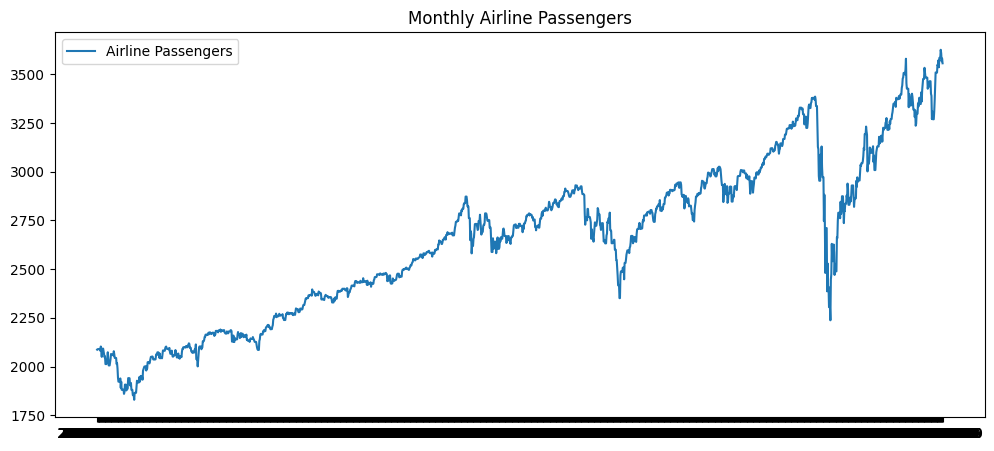

In [ ]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(12, 5))
# Assuming 'Date' is your x-axis and 'Close' is your y-axis
plt.plot(data['Date'], data['Close'], label='Airline Passengers')
plt.legend()
plt.title('Monthly Airline Passengers')
plt.show()

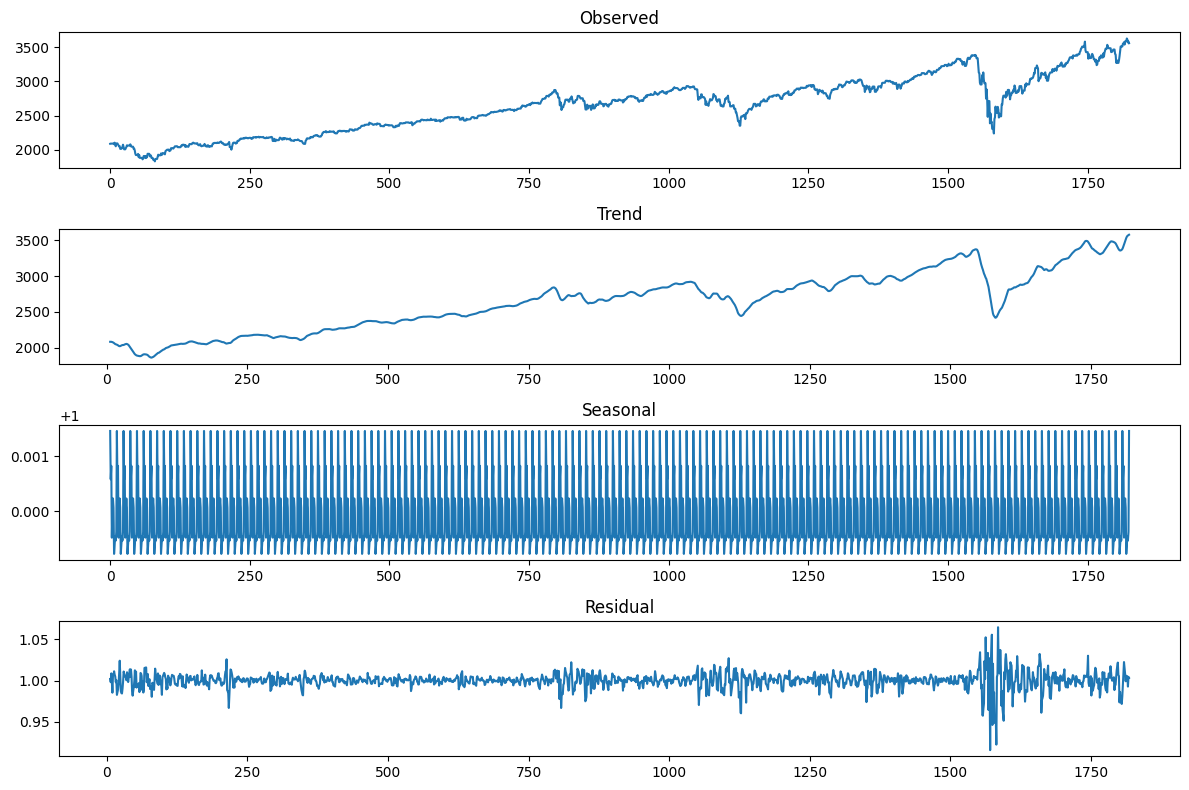

In [ ]:
# Time Series Decomposition
# Assuming 'Date' is your date column and 'Close' has the values you want to decompose
decomposition = seasonal_decompose(data['Close'], model='multiplicative', period=12)

fig, axes = plt.subplots(4, 1, figsize=(12, 8))
decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

In [ ]:
# Checking Stationarity & Transforming Data
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    return result[1] <= 0.05

In [ ]:
# Log Transformation to Stabilize Variance
# Select only the numeric columns for log transformation
numeric_cols = data.select_dtypes(include=np.number).columns
data_log = data.copy()
data_log[numeric_cols] = data_log[numeric_cols].apply(np.log)

if not check_stationarity(data_log['Close']):
    print("Data is not stationary after log transformation, applying first-order differencing...")
    data_diff = data_log['Close'].diff().dropna()
    if not check_stationarity(data_diff):
        print("Data is still not stationary, applying second-order differencing...")
        data_diff = data_diff.diff().dropna()
else:
    data_diff = data_log['Close']

ADF Statistic: -1.130202871405217
p-value: 0.7028783249517614
Critical Values:
   1%: -3.433990164137254
   5%: -2.8631479299063405
   10%: -2.567626009684832
Data is not stationary after log transformation, applying first-order differencing...
ADF Statistic: -8.438868229137682
p-value: 1.7856425238129693e-13
Critical Values:
   1%: -3.433990164137254
   5%: -2.8631479299063405
   10%: -2.567626009684832


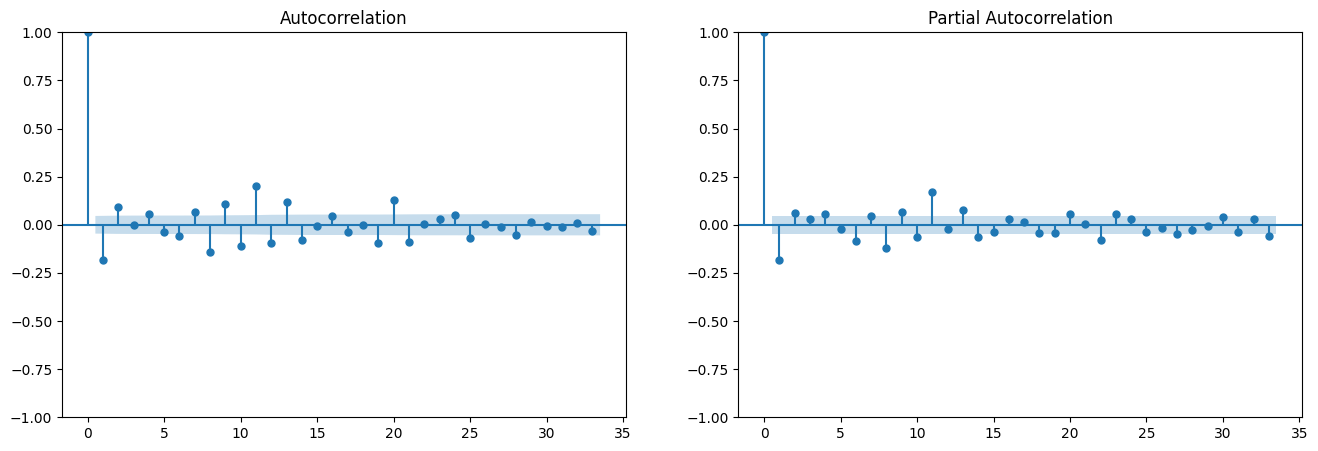

In [ ]:
# Autocorrelation & Partial Autocorrelation Plots
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(data_diff, ax=axes[0])
plot_pacf(data_diff, ax=axes[1])
plt.show()

In [ ]:
# Splitting Data
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

In [ ]:
# Splitting Data
train_size = int(len(data) * 0.8)
train, test = data['Close'].iloc[:train_size], data['Close'].iloc[train_size:] # Select only the 'Close' column for training

In [ ]:
# ... (Previous code for data preprocessing and splitting) ...

# Model Fitting
# Define the model order and seasonal order
p, d, q = 1, 1, 1  # Example values, adjust as needed
P, D, Q, s = 1, 1, 1, 12 # Example values, adjust as needed


model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit = model.fit()

# Model Evaluation
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}')

MAE: 188.4354222476231, MSE: 67782.05041767932, RMSE: 260.3498615664685


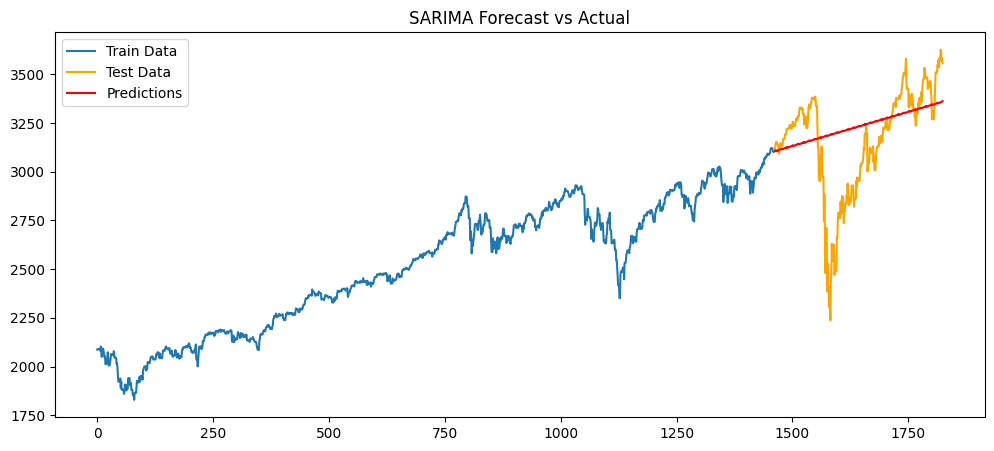

In [ ]:
# Plotting Predictions
plt.figure(figsize=(12, 5))
plt.plot(train, label='Train Data')
plt.plot(test, label='Test Data', color='orange')
plt.plot(predictions, label='Predictions', color='red')
plt.legend()
plt.title('SARIMA Forecast vs Actual')
plt.show()

In [ ]:
# Forecasting Future Values
future_steps = 12
forecast = model_fit.forecast(steps=future_steps)
print(f'Forecasted Values:\n{forecast}')

Forecasted Values:
1460    3104.020839
1461    3105.568436
1462    3107.091794
1463    3107.776243
1464    3110.420095
1465    3106.056598
1466    3109.066531
1467    3107.206317
1468    3107.424153
1469    3108.573298
1470    3111.366827
1471    3112.148187
Name: predicted_mean, dtype: float64


In [ ]:
# User Input & Prediction
steps = int(input("Enter the number of future steps to predict: "))
user_forecast = model_fit.forecast(steps=steps)
print(f'Predicted values for next {steps} steps:\n{user_forecast}')

Enter the number of future steps to predict: 10
Predicted values for next 10 steps:
1460    3104.020839
1461    3105.568436
1462    3107.091794
1463    3107.776243
1464    3110.420095
1465    3106.056598
1466    3109.066531
1467    3107.206317
1468    3107.424153
1469    3108.573298
Name: predicted_mean, dtype: float64


In [ ]:
# User Input & Prediction
steps = int(input("Enter the number of future steps to predict: "))
user_forecast = model_fit.forecast(steps=steps)
print(f'Predicted values for next {steps} steps:\n{user_forecast}')

Enter the number of future steps to predict: 10
Predicted values for next 10 steps:
1460    3104.020839
1461    3105.568436
1462    3107.091794
1463    3107.776243
1464    3110.420095
1465    3106.056598
1466    3109.066531
1467    3107.206317
1468    3107.424153
1469    3108.573298
Name: predicted_mean, dtype: float64
